# 线性回归从0开始开始实现

In [2]:
%matplotlib inline
import torch

## 生成数据集
$$
\mathbf{w}=\left[ 2,-3.4 \right] ^{\mathrm{T}},b=4.2
$$
$$
\mathbf{y}=\mathbf{Xw}+b+\epsilon 
$$
$\epsilon$ 为观测误差,服从均值为$0$的正态分布,这里标准差是$0.01$


In [3]:
def synthetic_data(w: torch.Tensor, b: torch.Tensor, num_examples: int):
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成正态分布的数据
    y = torch.matmul(X, w) + b  # 矩阵乘法
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [13]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [14]:
features

tensor([[ 0.0710, -1.5929],
        [-1.1677,  0.6827],
        [ 0.1895, -1.0535],
        ...,
        [ 0.1270, -1.0708],
        [-1.5898,  0.4854],
        [-0.9655,  1.3171]])

In [15]:
print("features:", features[0], '\n label:', labels[0])

features: tensor([ 0.0710, -1.5929]) 
 label: tensor([9.7661])


In [16]:
from d2l import torch as d2l

In [17]:
d2l.set_figsize()

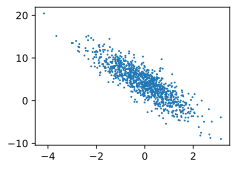

In [18]:
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)  # 画y与第2个特征的关系

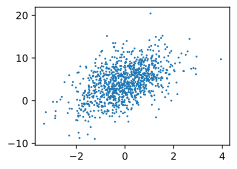

In [19]:
d2l.plt.scatter(features[:, (0)].detach().numpy(), labels.detach().numpy(), 1)

## 读取数据集

In [20]:
import random


def data_iter(batch_size, features, labels):
    nums_examples = len(features)
    indices = list(range(nums_examples))
    random.shuffle(indices)
    for i in range(0, nums_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, nums_examples)])
        yield features[batch_indices], labels[batch_indices]


In [21]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.1782, -0.6411],
        [-0.3286,  0.2049],
        [ 1.1714,  0.3831],
        [-0.0699,  1.5045],
        [ 0.1874, -1.0227],
        [ 1.1603, -1.5277],
        [ 0.5197,  0.3553],
        [-1.0263, -0.8633],
        [-0.3230, -0.8380],
        [-0.4285,  0.4224]]) 
 tensor([[ 6.0272],
        [ 2.8387],
        [ 5.2400],
        [-1.0429],
        [ 8.0564],
        [11.7198],
        [ 4.0192],
        [ 5.0903],
        [ 6.4112],
        [ 1.9236]])


## 初始化模型参数

从均值为$0$,标准差为$0.01$的正态分布中采样随机数来初始化权重,并将偏置项初始化为$0$

In [22]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 定义模型

In [24]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

## 定义损失函数

In [25]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2

## 定义优化算法

### 1. 为什么要在 `with torch.no_grad():` 下运行？

PyTorch 的核心优势之一是其**自动微分（Autograd）**引擎，它能够自动跟踪张量（Tensors）上的所有操作，并根据计算图反向传播计算梯度。

1.  **禁用梯度跟踪**：`torch.no_grad()` 是一个上下文管理器。当您在 `with torch.no_grad():` 块内执行代码时，PyTorch 会暂时禁用其自动微分功能。这意味着在此块内的所有张量操作都不会被记录以供后续的梯度计算。
2.  **优化器步骤的特性**：您提供的代码行 `param -= lr * param.grad / batch_size` 是**优化器**（在这个例子中是 SGD）用来**更新模型参数**的核心步骤。这个更新操作本身**不应该**被视为需要计算梯度的操作。换句话说，我们不希望 PyTorch 去计算“更新参数这个操作的梯度是多少”。
3.  **效率与内存**：禁用梯度跟踪可以显著提高计算效率，并减少内存消耗。因为 PyTorch 不需要存储中间结果来构建用于计算梯度的计算图。
4.  **避免错误计算**：如果不对参数更新步骤禁用梯度跟踪，那么当您在后续迭代中调用 `loss.backward()` 时，优化器本身的更新操作可能会被包含在计算图中，导致梯度计算的混乱和错误。

**数学表达**：
参数 $w$ 的更新规则可以表示为：
$w_{new} = w_{old} - \eta \cdot \frac{\partial L}{\partial w}$
其中：
*   $w_{old}$ 是参数的当前值。
*   $w_{new}$ 是更新后的新值。
*   $\eta$ 是学习率 ($lr$)。
*   $\frac{\partial L}{\partial w}$ 是损失函数 $L$ 对参数 $w$ 的梯度 ($param.grad$)。

在训练过程中，我们只想将计算出的梯度应用到模型权重上，而不需要计算“应用梯度”这个动作本身的梯度。因此，`torch.no_grad()` 确保了这部分代码不会影响未来的 `backward()` 调用。

### 2. 为什么最后还要把 `grad` 清零 (`param.grad.zero_()`)？

在 PyTorch 中，当您调用 `loss.backward()` 计算梯度时，它**默认会将新计算出的梯度累加到已经存在的 `.grad` 属性上**。

1.  **梯度累加**：PyTorch 的 `backward()` 方法会将当前计算得到的梯度值**加到**（而非覆盖）目标张量的 `.grad` 属性中。这是为了支持一些高级训练技巧，例如：
    *   **梯度累积 (Gradient Accumulation)**：在显存受限时，可以分批计算梯度，然后累加到一起，最后再进行一次参数更新，效果相当于使用更大的批次。
    *   **循环神经网络 (RNNs)**：在处理序列时，梯度可能需要跨时间步累积。
2.  **防止梯度污染**：然而，对于标准的 SGD 训练，我们希望**每一次**参数更新都只基于**当前 mini-batch** 的数据计算出的梯度。如果不清零，那么在第二批数据计算梯度时，会与第一批数据的梯度叠加，导致更新方向错误，模型无法正确收敛。
3.  **`zero_()` 的作用**：`param.grad.zero_()` 方法会将该参数的梯度张量中的所有元素设置为零，并且是**原地修改（in-place）**。这样做是为了确保在处理下一个 mini-batch 之前，梯度被重置，从而使下一次 `loss.backward()` 计算的梯度是全新的，不包含前一个 batch 的信息。

**数学表达**：
假设在第 $k$ 批次训练后，参数 $w$ 的梯度是 $\nabla_w L_k$。
如果直接进行多次 $w = w - \eta \nabla_w L_i$，但实际执行的是：
*   `loss_k.backward()` -> `param.grad` 累加了 $\nabla_w L_k$
*   `param -= lr * param.grad` -> $w_{k+1} \approx w_k - \eta \cdot (\nabla_w L_1 + \nabla_w L_2 + ... + \nabla_w L_k)$
这是不正确的。

正确做法是：
*   `loss_k.backward()` -> 此时 `param.grad` 只有 $\nabla_w L_k$
*   `param -= lr * param.grad` -> $w_{k+1} = w_k - \eta \cdot \nabla_w L_k$
*   `param.grad.zero_()` -> 清零，为下一批次 $\nabla_w L_{k+1}$ 准备。

In [26]:
import torch

def sgd(params, lr, batch_size):
    # lr 是学习率
    with torch.no_grad():
        for param in params:
            # param.grad 存储了参数 param 相对于损失函数的梯度
            # 梯度更新公式：参数 = 参数 - 学习率 * 梯度
            # 这里除以 batch_size 通常是为了使用平均梯度（如果 param.grad 是梯度的总和）
            param -= lr * param.grad / batch_size
            # 将参数的梯度清零，为下一次计算做准备
            param.grad.zero_()

In [27]:
lr = 0.03
nums_epochs = 3
net = linreg
loss = squared_loss

In [28]:
lr = 0.03 # 学习率
nums_epochs = 3 # 训练轮数（epochs）
net = linreg # 指定模型函数
loss = squared_loss # 指定损失函数

# 训练开始
for epoch in range(nums_epochs): # 遍历每一轮训练
    # 在每一轮中，遍历所有数据批次
    for X, y in data_iter(batch_size, features, labels):
        # 1. 前向传播: 计算当前批次的预测值和损失
        # net(X, w, b) 计算预测值 y_hat
        # loss(net(X, w, b), y) 计算损失 l
        l = loss(net(X, w, b), y)

        # 2. 反向传播: 计算损失 L 对模型参数 w 和 b 的梯度
        # l 是一个张量，需要先求和变成标量才能调用 backward()
        # l.sum() 负责将批次内的损失加总
        l.sum().backward()

        # 3. 参数更新: 使用 SGD 更新模型参数 w 和 b
        # sgd 函数会根据计算出的梯度 (w.grad, b.grad) 来更新 w 和 b
        sgd([w, b], lr, batch_size)

    # 4. 周期性评估/打印: 每轮训练结束后，计算整个数据集上的平均损失
    # 如果去掉 with torch.no_grad():，它不会对打印出的损失值本身造成影响，也不会影响到下一轮训练中 w 和 b 的值。但是，它会严重影响性能
    with torch.no_grad(): # 不跟踪梯度，因为只是评估，不需要反向传播
        # 使用训练好的参数 w, b 计算整个数据集 (features, labels) 上的损失
        train_ll = loss(net(features, w, b), labels)
        # 打印当前轮次的 epoch 编号和平均损失
        # train_ll.mean() 计算整个数据集上损失的平均值
        print(f'epoch {epoch}, loss: {float(train_ll.mean()):f}')

epoch 0, loss: 0.000226
epoch 1, loss: 0.000106
epoch 2, loss: 0.000106


In [29]:
print(f'w的误差:{true_w - w.reshape(true_w.shape)}')

w的误差:tensor([-0.0006,  0.0005], grad_fn=<SubBackward0>)


In [30]:
print(f'b的误差:{true_b - b}')

b的误差:tensor([-0.0006], grad_fn=<RsubBackward1>)


# 练习

### 1. 如果我们将权重初始化为零，会发生什么。算法仍然有效吗？

如果我们将权重 $w$ 和偏置 $b$ 都初始化为零，那么在训练的起始阶段，模型的预测值 $\hat{y} = Xw + b$ 对于任何输入 $X$ 都将是零。

**由此带来的问题：**
在第一次迭代中，计算损失并反向传播梯度时，所有用于更新权重 $w$ 的梯度将是相同的（假设批次中所有样本的特征都经过了相同的变换）。这是因为模型输出对权重的梯度是输入特征 $X$。如果 $w$ 的所有元素都初始化为零，那么梯度的计算 $\nabla_{w} L = X^T (Xw + b - y)$ 在 $w=0, b=0$ 时，对于批次中的所有样本，梯度方向会指向相同，导致所有特征对应的权重 $w$ 在第一次更新时以相同的方式改变。

更糟糕的是，如果数据集中存在对称性，或者某些特征之间高度相关，在这种情况下，所有权重可能会收敛到相同的值。这将导致模型无法区分不同特征的重要性，或者无法学习到特征之间的非线性组合（虽然线性回归本身是线性的，但不同特征应有不同的权重表示其独立贡献）。

**算法是否有效？**
从算法执行的 *合法性* 而言，算法仍然是有效的。它仍然会计算梯度并更新参数。然而，从 *学习效果* 而言，这种初始化方式可能会严重阻碍模型的有效学习，导致收敛缓慢或收敛到次优解，尤其是当模型具有多个输入特征时。在实际应用中，我们通常会采用随机初始化（如正态分布或均匀分布）来打破这种对称性。

---

### 2. 假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?

**答案是肯定的。**

电压 ($V$) 和电流 ($I$) 之间的关系，在许多情况下（例如欧姆定律 $V = IR_0$），可以被建模为一个线性关系，其中电压是电流的函数，而电阻 ($R_0$) 是模型的参数。

如果我们的模型是 $V = R_0 \cdot I$，其中 $R_0$ 是我们要学习的参数。假设我们收集了一系列电流 $I$ 和对应的电压 $V$ 的观测数据。我们可以将问题转化为一个回归问题：

*   **自变量（特征）：** 电流 $I$
*   **因变量（标签）：** 电压 $V$
*   **模型参数：** 电阻 $R_0$

我们可以定义一个损失函数，例如均方误差 (MSE)，来衡量模型预测的电压 $\hat{V} = R_0 \cdot I$ 与实际观测电压 $V$ 之间的差异：
$$ L(R_0) = \frac{1}{N} \sum_{i=1}^{N} (\hat{V}_i - V_i)^2 = \frac{1}{N} \sum_{i=1}^{N} (R_0 \cdot I_i - V_i)^2 $$

**自动微分的作用：**
自动微分（AutoGrad）正是用来计算这个损失函数 $L(R_0)$ 相对于参数 $R_0$ 的梯度 $\frac{dL}{dR_0}$。一旦我们有了梯度，就可以使用梯度下降等优化算法来更新 $R_0$，直到损失函数最小化，从而找到最适合数据的电阻值。

因此，自动微分在物理建模和参数学习中是非常有用的工具。

---

### 3. 能基于普朗克定律使用光谱能量密度来确定物体的温度吗？

**答案是肯定的。**

普朗克定律描述了黑体在特定温度下，在不同波长上的能量辐射分布。其光谱辐射亮度（spectral radiance）的公式为：
$$ B_\lambda(\lambda, T) = \frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k_B T}} - 1} $$
其中：
*   $B_\lambda(\lambda, T)$ 是波长为 $\lambda$、温度为 $T$ 时的光谱辐射亮度。
*   $h$ 是普朗克常数。
*   $c$ 是光速。
*   $k_B$ 是玻尔兹曼常数。
*   $\lambda$ 是波长。
*   $T$ 是绝对温度。

这个公式建立了光谱能量密度（或辐射亮度）与温度 $T$ 之间的直接关系。

**如何确定温度：**
1.  **测量：** 我们可以通过仪器（如光谱仪）测量一个物体在不同波长 $\lambda$ 上的光谱能量密度 $B_{\lambda, \text{measured}}$。
2.  **建模：** 我们可以将普朗克定律看作一个模型，其参数是对物体温度 $T$ 的一个函数。
3.  **优化：** 我们定义一个损失函数，例如均方误差，来衡量测量值与模型预测值之间的差异：
    $$ L(T) = \sum_{i} \left( B_{\lambda_i, \text{measured}} - B_\lambda(\lambda_i, T) \right)^2 $$
    其中 $\lambda_i$ 是我们测量波长的集合。

通过使用自动微分计算损失函数 $L(T)$ 对温度 $T$ 的梯度 $\frac{dL}{dT}$，并结合优化算法（如梯度下降），我们可以迭代地调整 $T$ 的值，直到找到一个 $T$，使得模型预测的光谱能量密度最拟合测量到的光谱能量密度。这个过程就是基于光谱能量密度的温度测量（例如红外测温仪的工作原理）。

---

### 4. 计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？

计算二阶导数（如 Hessian 矩阵）在优化算法（如牛顿法）和一些机器学习技术（如二阶信息论方法）中非常重要。但它也带来了一系列挑战：

**可能遇到的问题：**

1.  **计算复杂度高：**
    *   对于一个有 $N$ 个参数的模型，Hessian 矩阵的大小是 $N \times N$。计算所有二阶偏导数并组成 Hessian 矩阵的计算量很大。
    *   存储 $N \times N$ 的矩阵也需要大量的内存。
    *   在优化过程中，每次迭代都需要计算或操作 Hessian 矩阵（如计算逆矩阵或求解线性系统），这会显著增加计算时间。

2.  **数值不稳定性和精度损失：**
    *   在数值计算中，计算导数的导数（即二阶导数）比计算一阶导数更容易累积数值误差。
    *   当函数值或一阶导数非常接近时，计算差值可能会导致“取消误差”（cancellation error），显著降低精度。
    *   特别是在深度学习中，梯度可能变得非常小（梯度消失）。对这些极小的梯度再求导，可能导致数值问题。

3.  **Hessian 矩阵的性质：**
    *   **非正定性 (Non-positive definiteness)：** Hessian 矩阵可能不是半正定的。如果不是半正定的，牛顿法（它依赖于 Hessian 的正定性来保证下降方向）的更新方向可能不是一个下降方向，导致优化不稳定。
    *   **病态 (Ill-conditioning)：** Hessian 矩阵的条件数可能很大，这意味着矩阵接近奇异，求解线性系统 $\mathbf{H}\mathbf{x} = -\nabla f$ 时对 $\nabla f$ 中的微小扰动非常敏感，导致计算结果不稳定。

4.  **实现复杂性：**
    *   手动推导和实现二阶导数对于复杂的模型可能非常困难且容易出错。

**如何解决这些问题：**

1.  **近似方法：**
    *   **有限差分法 (Finite Differences)：** 可以用来近似 Hessian 矩阵的元素，但也会引入截断误差和舍入误差。
    *   **拟牛顿法 (Quasi-Newton Methods)：** 例如 BFGS、L-BFGS。这些方法通过一系列迭代来*近似* Hessian 矩阵的逆，而无需直接计算。L-BFGS（Limited-memory BFGS）尤其适合处理高维参数空间，因为它只存储有限数量的过去梯度和位移信息，而不是整个 Hessian 矩阵。

2.  **避免显式计算 Hessian：**
    *   **Hessian-Vector Products (HVPs)：** 许多算法（如共轭梯度法用于求解牛顿步）只需要计算 Hessian 矩阵与一个向量的乘积，而不是整个 Hessian 矩阵。通过自动微分的“巧妙”组合（如前向模式 AD 和反向模式 AD 的组合），可以在不显式构造 Hessian 的情况下高效计算 HVPs。
    *   **随机方法：** 例如，对 Hessian 矩阵的某些部分（如对角线）进行估计，或使用随机梯度下降的变种。

3.  **处理非正定性：**
    *   **修改牛顿法：** 当 Hessian 非正定时，可以对其进行修改（例如，添加一个对角线矩阵，使其半正定）或者回退到梯度下降；或者使用 Levenberg-Marquardt 算法，它混合了牛顿法和最速下降法的思想。

4.  **使用自动微分库：**
    *   现代深度学习框架（如 PyTorch, TensorFlow）提供了强大的自动微分功能，可以自动计算二阶导数。虽然这解决了实现复杂性问题，但计算和内存的挑战依然存在。用户可以选择仅计算某些部分的导数，或者利用库提供的 L-BFGS 等优化器。

---

### 5. 为什么在 squared_loss 函数中需要使用 reshape 函数？

在 `squared_loss` 函数中，我们计算的是 $(y_{hat} - y)^2$。这里的 `reshape` 函数（虽然在您提供的代码片段中是 `y.reshape(y_hat.shape)`）是为了确保计算能够正确地逐元素进行。

让我们分析一下 `y_hat` 和 `y` 的典型形状：

*   `y_hat` 是 `linreg(X, w, b)` 的输出。如果 `X` 的形状是 `(batch_size, n_features)`，`w` 的形状是 `(n_features, 1)`，那么 `torch.matmul(X, w)` 的形状是 `(batch_size, 1)`。将偏置 $b$（形状为 `(1,)`）加到这个结果上，会发生广播，最终 `y_hat` 的形状通常是 `(batch_size, 1)`。
*   `y`（标签）的形状可能因数据加载方式而异。有时，它被加载为形状为 `(batch_size,)` 的一维张量。

**需要 `reshape` 的理由：**

1.  **逐元素运算兼容性：** 尽管 PyTorch 的张量运算（如减法、乘法）具有一定的广播（broadcasting）能力，但显式地确保两个张量的形状匹配可以避免潜在的歧义和运行时错误。
2.  **精确匹配：** 当 `y_hat` 是 `(batch_size, 1)` 而 `y` 是 `(batch_size,)` 时，直接相减可能会依赖于 PyTorch 的默认广播规则（将 `y` 广播为 `(batch_size, 1)`）。调用 `y.reshape(y_hat.shape)`（或者更精确地，`y.view(y_hat.shape)` 或 `y.unsqueeze(1)`）会明确地将 `y` 转换成形状 `(batch_size, 1)`。这样，`y_hat` 和 `y` 就有了完全相同的形状 `(batch_size, 1)`，可以确保它们之间的减法是以逐元素的方式进行的，并且后续的平方操作也是逐元素的。
3.  **避免意外行为：** 如果 `y` 来自一个批次 `batch_size` 无法被整除的最后一个批次，其形状可能仍然是 `(batch_size,)`。`y_hat.shape` 确保了即使 `y_hat` 的最后一个维度是 1，`y` 也会被调整以匹配，以便计算 `(y_hat - y)` 的差值。

简而言之，`reshape` 确保了 `y_hat` 和 `y` 在进行减法和平方运算时，它们的形状是完全对齐的，从而保证了损失计算的准确性。

---

### 6. 尝试使用不同的学习率，观察损失函数值下降的快慢。

这是一个实验性的问题，旨在理解**学习率 (learning rate, $lr$)** 这个超参数对模型训练过程的影响。

**实验操作：**
您需要修改代码中的 `lr` 变量，例如尝试 `lr = 0.001`, `lr = 0.01`, `lr = 0.03`, `lr = 0.1`, `lr = 0.5` 等，然后运行整个训练循环，并关注每一轮（epoch）结束后打印出的 `loss` 值。

**预期的观察结果：**

*   **过小的学习率 (e.g., $lr = 0.001$)：**
    *   损失函数值下降会非常缓慢。
    *   可能需要更多的训练轮次才能达到一个相对较低的损失。
    *   损失函数下降的曲线会显得非常平缓。

*   **适中的学习率 (e.g., $lr = 0.01, 0.03$)：**
    *   损失函数值会以一个比较合理的速度下降。
    *   模型能够较快地收敛到一个较低的损失值。
    *   这是我们期望的“良好”学习率范围。

*   **过大的学习率 (e.g., $lr = 0.1, 0.5$)：**
    *   损失函数值可能会剧烈波动，甚至在某些轮次中不降反升（发散）。
    *   如果损失值爆炸性增长，模型将无法学习。
    *   即使不完全发散，训练过程也可能不稳定，难以到达最优解。

**结论：**
选择一个合适的学习率至关重要。学习率过小会导致训练效率低下，而学习率过大则可能导致训练不稳定甚至发散。通过实验调整学习率，是超参数调优的重要一环。

---

### 7. 如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？

在 `data_iter` 函数中，核心在于：
```python
for i in range(0, nums_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i + batch_size, nums_examples)])
    yield features[batch_indices], labels[batch_indices]
```

**分析：**

1.  **`range(0, nums_examples, batch_size)`：** 这个 `range` 函数会生成起始索引，例如：如果 `nums_examples = 100` 且 `batch_size = 16`，它会生成 `0, 16, 32, 48, 64, 80, 96`。
2.  **`indices[i:min(i + batch_size, nums_examples)]`：** 这是关键部分。
    *   当 `i = 0, 16, 32, 48, 64, 80` 时，`i + batch_size` (例如 `80 + 16 = 96`) 小于 `nums_examples` (100)。所以 `min(i + batch_size, nums_examples)` 等于 `i + batch_size`。此时，切片 `indices[i : i + batch_size]` 能取出 `batch_size` 个索引，形成一个完整的批次。
    *   当 `i = 96` 时，`i + batch_size` (即 `96 + 16 = 112`) 大于 `nums_examples` (100)。这时 `min(i + batch_size, nums_examples)` 的结果是 `nums_examples` (100)。切片 `indices[96 : 100]` 就只能取出 `nums_examples - 96 = 4` 个索引。

**结论：**

如果样本总数 `nums_examples` 不能被 `batch_size` 整除，`data_iter` 函数的行为 **不会发生错误**。它会照常工作，但：
*   **最后一个批次的大小会小于 `batch_size`**。它将包含所有剩余的样本。
*   **模型仍会处理所有样本**，只是最后一个批次的梯度计算和更新将基于一个较小的样本集。

这种处理方式是完全可以接受的，并且在现代深度学习框架中是常见的做法。
